In [13]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import combinations
from math import comb
from time import time
from datetime import date
import warnings
from joblib import Parallel, delayed
import json
import copy
from collections import defaultdict

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, plot_confusion_matrix, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

warnings.filterwarnings('ignore')
# pd.set_option('mode.chained_assignment', None)

In [14]:
WORDSIM_DF = '../data/evaluation/wordsim353_with_r3.csv'
WORDSIM_OLD_FINAL_FILE = "../data/evaluation/wordsim_old.csv"
DBPEDIA_MC_30_FINAL_FILE = "../data/evaluation/mc-30_DBpedia.csv"
DBPEDIA_RG_65_FINAL_FILE = "../data/evaluation/rg-65_DBpedia.csv"

CONCEPTNET_FILE = "../data/evaluation/kgtk_conceptnet_final.csv"
WIKI_CS_FILE = '../data/evaluation/wikidata-cs_final.csv'

INPUT_EMB_FOLDER_PATH = '../data/embeddings/'

In [15]:
# basis
P279_CHILD_PAR_DISTILBERT_COSSIM_FILE = "../data/basis/P279_ChildPar.all-distilroberta-v1.csv"
P279_SIBLINGS_DISTILBERT_COSSIM_FILE = "../data/basis/P279_Siblings.all-distilroberta-v1.csv"

P279_CHILD_PAR_CLASSSIM_FILE = "../data/basis/P279_ChildPar.classSim.csv"
P279_SIBLINGS_CLASSSIM_FILE = "../data/basis/P279_Siblings.classSim.csv"

PROBASE_FINAL_FILE = '../data/basis/intermediate_files/probase_WQnodes_subset_and_sim.csv'


In [16]:
WORDSIM_CLASS_SIM_FILE = '../data/embeddings/wordsim_class_sim.csv'
WORDSIM_JC_SIM_FILE = '../data/embeddings/wordsim_jc_sim.csv'
WORDSIM_TOP_SIM_FILE = '../data/embeddings/wordsim_top_sim.csv'

WORDSIM_OLD_CLASS_SIM_FILE = '../data/embeddings/wordsim_old_class_sim.csv'
WORDSIM_OLD_JC_SIM_FILE = '../data/embeddings/wordsim_old_jc_sim.csv'
WORDSIM_OLD_TOP_SIM_FILE = '../data/embeddings/wordsim_old_top_sim.csv'

# Retrofitting Pre-Req Class Definitions

## Utils

In [54]:
class Utils:
    """
    This contains all the utility functions needed by any part of retrofitting
    """
    _today = date.today()
    today_date = _today.strftime("%b_%d_%Y")
    LABELS = ['I','M','U']
    
    @classmethod
    def normalize(cls, embed_dict):
        for key, val in embed_dict.items():
            temp = np.array([float(val1) for val1 in val])
            temp2 = temp**2
            embed_dict[key] = temp / np.sqrt((temp2.sum() + 1e-6))
        return embed_dict
    
    @classmethod
    def fetch_embeddings(cls, df):
        embed_dict = {}
        for _, row in df.iterrows():
            embed_dict[row.node] = row.value
        return normalize(embed_dict)
    
    @classmethod
    def fill_coverage(cls, embed_dict, embed_name):
        wordsim_df = pd.read_csv(WORDSIM_DF)
#         wiki_cs_df = pd.read_csv(WIKICS_DF)
#         concept_net_df = pd.read_csv(CONCEPTNET_DF)
        
        compulsory_coverage_set = set(
                        wordsim_df['word1_kg_id'].to_list() 
                        + wordsim_df['word2_kg_id'].to_list())
#                         + wiki_cs_df['word1_kg_id'].to_list() 
#                         + wiki_cs_df['word2_kg_id'].to_list()
#                         + concept_net_df['word1_kg_id'].to_list()
#                         + concept_net_df['word2_kg_id'].to_list())
        
        embed_size = len(embed_dict[next(iter(embed_dict))])
        count = 0
        for word in compulsory_coverage_set:
            if word not in embed_dict:
                embed_dict[word] = np.zeros((embed_size))
                count += 1
        print(f"Added {count} corrections to {embed_name}")
        return embed_dict
    
    @classmethod
    def check_coverage(cls, embed_dict):
        wordsim_df = pd.read_csv(WORDSIM_DF)
        
        compulsory_coverage_set = set(list(zip(wordsim_df['word1_kg_id'].to_list(), wordsim_df['word2_kg_id'].to_list())))
        embed_size = len(embed_dict[next(iter(embed_dict))])
        count = 0
        for word1, word2 in compulsory_coverage_set:
            if word1 not in embed_dict or word2 not in embed_dict:
                count += 1
        return (len(wordsim_df) - count)
    
    @classmethod
    def find_missing_words(cls, embed_dict):
        wordsim_df = pd.read_csv(WORDSIM_DF)
        
        compulsory_coverage_set = set((wordsim_df['word1_kg_id'].to_list()) + (wordsim_df['word2_kg_id'].to_list()))
        embed_size = len(embed_dict[next(iter(embed_dict))])
        missing_words = []
        for word in compulsory_coverage_set:
            if word not in embed_dict or not(embed_dict[word].any()):
                missing_words.append(word)
        return missing_words
    
    @classmethod
    def determine_distances(cls, embed_dict, new_embed_dict):
        dist = []
        for word in embed_dict.keys():
            dist.append(euclidean_distances([embed_dict[word]], [new_embed_dict[word]])[0][0])
        return dist
    
    @classmethod
    def serialize_embedding_dict(cls, embed_dict):
        for key2 in embed_dict.keys():
            embed_dict[key2] = embed_dict[key2].tolist() if type(embed_dict[key2]) != list else embed_dict[key2]
        return embed_dict
    
    @classmethod
    def deserialize_embedding_dict(cls, embed_dict):
        for key2 in embed_dict.keys():
            embed_dict[key2] = np.array(embed_dict[key2])
        return embed_dict
    
    @classmethod
    def label_samples(cls, score):
        return 'I' if score <= 1.75 else 'U' if score >= 3.5 else 'M'
    
    @classmethod
    def alt_label_samples(cls, score, quartiles):
        return ['Q'+str(i+1) for i in range(len(quartiles) - 1) if quartiles[i] <= score < quartiles[i+1]][0]
    
    @classmethod
    def alt2_label_samples(cls, row, quartiles):
        return [i for i, quartile in (quartiles.items()) if (row.word1_kg_id, row.word2_kg_id) in quartile][0]
    
    @classmethod
    def determine_cos_sim(cls, emb1, emb2):
        return cosine_similarity(
                np.array(emb1).reshape(1,-1), 
                np.array(emb2).reshape(1,-1)
            )[0][0]
    
    @classmethod
    def plot_confusion_matrix(cls, conf_matrix, title):
        plt.close()
        sns.heatmap(conf_matrix, xticklabels=Utils.LABELS, yticklabels=Utils.LABELS, annot=True)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(title+' Confusion Matrix')

In [18]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

#     for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                              key= lambda x: -x[1])[:10]:
#         print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

## Inputs

In [72]:
class InputEmbeddings:
    """
    Instance variables:
        - embed_dict_master - holds all qnode to embedding mappings as a dictionary
        - embedding_list - list of all keys of the above dictionary
    """
    def __init__(self, has_embeddings_include: bool = True):
        self.embed_dict_master = {}
        self.emb_list = ['text_7_props', 'complex', 'transe', 'abstract_first_sent']
        if has_embeddings_include: # TODO
            self.emb_list += ['has_h', 'has_s']
        self.embedding_lengths = {}
        
        for emb_key in tqdm(self.emb_list, desc='Input Embeddings', leave=False):
            self.embed_dict_master[emb_key] = self.fetch_embedding(emb_key)
            
        self.fetch_embedding_stats()
        print("Fetched all input embeddings")

    def fetch_embedding(self, emb_key):
        emb = Utils.deserialize_embedding_dict(
                json.load(open(INPUT_EMB_FOLDER_PATH+emb_key+'_orig_embedding_dict.json'))
            )
        print(f"OG Coverage of {emb_key}: {Utils.check_coverage(emb)}")
        return Utils.fill_coverage(
                emb, emb_key
            )

    def fetch_embedding_stats(self):
        for emb_name in self.embed_dict_master.keys():
            self.embedding_lengths[emb_name] = len(next(iter(self.embed_dict_master[emb_name].values())))
            print(f"Embedding: {emb_name}, Size: {len(self.embed_dict_master[emb_name].keys())}, Length: {self.embedding_lengths[emb_name]}")

class ReducedInputEmbeddings:
    def __init__(self, embed_dict_master, final_embed_len):
        self.embed_dict_master = copy.deepcopy(embed_dict_master)
        self.final_embed_len = final_embed_len
        for key in tqdm(self.embed_dict_master.keys()):
#             tsne = TSNE(final_embed_len, verbose=1, method='exact')
            tfmr = PCA(final_embed_len)
            tfmr_proj = tfmr.fit_transform(pd.DataFrame(list(self.embed_dict_master[key].values())))
            tfmr_proj = normalize(tfmr_proj, axis=0)
            for w_key, emb in zip(self.embed_dict_master[key].keys(), tfmr_proj):
                self.embed_dict_master[key][w_key] = emb        
                
    def generate_concatenated_embedding_dict(self, key_comb):
        embedDict = defaultdict(list)
        masterKeySet = set()
        for key in key_comb:
            for qnode in self.embed_dict_master[key]:
                masterKeySet.add(qnode)
        for qnode in masterKeySet:
            for key in key_comb:
                if qnode in self.embed_dict_master[key]:
                    embedDict[qnode] = embedDict[qnode] + (self.embed_dict_master[key][qnode].tolist())
                else:
#                     print("Hit missing elem branch for concatenation")
                    embedDict[qnode] = embedDict[qnode] + [0]*self.final_embed_len
            embedDict[qnode] = np.array(embedDict[qnode])
        return dict(embedDict)

class InputScoreTables:
    def __init__(self, embed_dict_master, exception_cols, wordsim_new=True):
        self.input_score_tables = {}
        self.wordsim_new = wordsim_new
        print(f"Fetching {'new' if wordsim_new else 'old'} wordsim score tables and eval file")
        if wordsim_new:
            self.input_score_tables['classSim'] = pd.read_csv(WORDSIM_CLASS_SIM_FILE)
            self.input_score_tables['JC'] = pd.read_csv(WORDSIM_JC_SIM_FILE)
            self.input_score_tables['topSim'] = pd.read_csv(WORDSIM_TOP_SIM_FILE)
            self.wordsim = evalD.wordsim_df.copy()
        else:
            self.input_score_tables['classSim'] = pd.read_csv(WORDSIM_OLD_CLASS_SIM_FILE)
            self.input_score_tables['JC'] = pd.read_csv(WORDSIM_OLD_JC_SIM_FILE)
            self.input_score_tables['topSim'] = pd.read_csv(WORDSIM_OLD_TOP_SIM_FILE)
            self.wordsim = evalD.old_wordsim_df.copy()
            
        self.input_score_tables['classSim']['embedding_na'] = self.input_score_tables['classSim']['embedding_cos_sim'].isna()
        self.input_score_tables['classSim'] = self.input_score_tables['classSim'][self.input_score_tables['classSim'].word1_kg_id == self.input_score_tables['classSim'].word2_kg_id]
        self.input_score_tables['JC']['embedding_na'] = self.input_score_tables['JC']['embedding_cos_sim'].isna()
        self.input_score_tables['JC'] = self.input_score_tables['JC'][self.input_score_tables['JC'].word1_kg_id == self.input_score_tables['JC'].word2_kg_id]
        self.input_score_tables['topSim']['embedding_na'] = self.input_score_tables['topSim']['embedding_cos_sim'].isna()
        self.input_score_tables['topSim'] = self.input_score_tables['topSim'][self.input_score_tables['topSim'].word1_kg_id == self.input_score_tables['topSim'].word2_kg_id]
        
        if embed_dict_master is not None:
            for emb in embed_dict_master:
#                 print(f"Emb: {emb}")
                self.input_score_tables[emb] = self.construct_wsim_tab(embed_dict_master[emb])
        self.input_score_tables['average'] = self.get_averaged_dict(exception_cols)
    
    def construct_wsim_tab(self, embed_dict):
        if self.wordsim_new:
            eval_dataset = evalD.wordsim_df.copy()
        else:
            eval_dataset = evalD.old_wordsim_df.copy()

        eval_dataset['embedding_cos_sim'] = eval_dataset.apply(lambda p: Utils.determine_cos_sim(embed_dict[p['word1_kg_id']], embed_dict[p['word2_kg_id']]) 
                                                   if p['word1_kg_id'] in embed_dict and p['word2_kg_id'] in embed_dict 
                                                   else None, axis=1)
        eval_dataset['embedding_na'] = eval_dataset['embedding_cos_sim'].isna()
#         print(f"Coverage: {len(eval_dataset) - eval_dataset['embedding_cos_sim'].isna().sum()}")
        eval_dataset['embedding_cos_sim'].fillna(eval_dataset['embedding_cos_sim'].mean(skipna=True), inplace=True)
        
        # Scale abs value of cosine similarities to 1,4 strictly
        eval_dataset['embedding_cos_sim'] = eval_dataset['embedding_cos_sim'].apply(lambda p: 4 - 3 * abs(p))
        
        return eval_dataset
        
    def get_pairwise_dict(self, tab_key):
        if tab_key not in self.input_score_tables:
            raise "Key not present in table"
        return {(row['word1_kg_id'], row['word2_kg_id']): row['embedding_cos_sim'] for _, row in self.input_score_tables[tab_key].iterrows()}
    
    def get_averaged_dict(self, exception_cols):
        print(f"Returning averaged scores from {len(set(self.input_score_tables.keys()) - exception_cols)} algorithms - {set(self.input_score_tables.keys()) - exception_cols}")
        final_dict = defaultdict(list)
        for tab_key in set(self.input_score_tables.keys()) - exception_cols:
            for _, row in self.input_score_tables[tab_key].iterrows():
                if row['embedding_na'] == False:
                    final_dict[(row['word1_kg_id'], row['word2_kg_id'])].append(row['embedding_cos_sim'])
                else:
                    print('na embedding was present, hence skipped')
        for key in final_dict:
            final_dict[key] = np.mean(np.array(final_dict[key]))
        
        if self.wordsim_new:
            eval_dataset = evalD.wordsim_df.copy()
        else:
            eval_dataset = evalD.old_wordsim_df.copy()

        eval_dataset['embedding_cos_sim'] = eval_dataset.apply(lambda p: final_dict[(p['word1_kg_id'], p['word2_kg_id'])], axis=1)
        
        return eval_dataset

## NeighborDatasets

In [20]:
class NeighborDatasets:
    """
    Instance variables:
        - neighbors_dict_master - holds all qnode to neighbor qnode mappings as a dictionary
        - basis_list - list of all keys of the above dictionary
    """
    
    def __init__(self, class_datasets_fetch: bool = False, probase_datasets_fetch: bool = True):
        self.neighbors_dict_master = {}
        
        pbar = tqdm(desc='Neighbor Datasets', leave=False, total = 
                    3
                    + (3 if class_datasets_fetch else 0) 
                    + (1 if probase_datasets_fetch else 0) 
                   )
        
        bert_P279_child_par_df = pd.read_csv(P279_CHILD_PAR_DISTILBERT_COSSIM_FILE)
#         bert_P279_child_par_df_cross_enc = pd.read_csv('../data/Master_P279_dataset/P279ChildPar_filtered_cross_enc.csv')
        bert_P279_siblings_df = pd.read_csv(P279_SIBLINGS_DISTILBERT_COSSIM_FILE)
#         bert_P279_siblings_df_cross_enc = pd.read_csv('../data/Master_P279_dataset/P279Siblings_transP279_filtered_min_cols_with_desc_dups_removed_cross_enc.csv')
        
        self.neighbors_dict_master['bert_child_par'] = self.fetch_neighbours(bert_P279_child_par_df)
        pbar.update(1)
        self.neighbors_dict_master['bert_siblings'] = self.fetch_neighbours(bert_P279_siblings_df)
        pbar.update(1)
        self.neighbors_dict_master['bert_all'] = self.fetch_neighbours(pd.concat([
                bert_P279_child_par_df, bert_P279_siblings_df
            ]))
        pbar.update(1)
        
#         self.neighbors_dict_master['cross_enc_child_par'] = self.fetch_neighbours(bert_P279_child_par_df)
#         pbar.update(1)
#         self.neighbors_dict_master['cross_enc_siblings'] = self.fetch_neighbours(bert_P279_siblings_df)
#         pbar.update(1)
#         self.neighbors_dict_master['cross_enc_all'] = self.fetch_neighbours(pd.concat([
#                 bert_P279_child_par_df, bert_P279_siblings_df
#             ]))
#         pbar.update(1)
            
        if class_datasets_fetch:
            class_P279_child_par_df = pd.read_csv(P279_CHILD_PAR_CLASSSIM_FILE)
            class_P279_child_par_df['similarity_value'] = class_P279_child_par_df['classSim']
            
            class_P279_siblings_df = pd.read_csv(P279_SIBLINGS_CLASSSIM_FILE)
            class_P279_siblings_df['similarity_value'] = class_P279_siblings_df['classSim']
            
            self.neighbors_dict_master['class_child_par'] = self.fetch_neighbours(class_P279_child_par_df)
            pbar.update(1)
            self.neighbors_dict_master['class_siblings'] = self.fetch_neighbours(class_P279_siblings_df)
            pbar.update(1)
            self.neighbors_dict_master['class_all'] = self.fetch_neighbours(pd.concat([
                    class_P279_child_par_df, class_P279_siblings_df
                ]))
            pbar.update(1)

        if probase_datasets_fetch:
            probase_df = self.process_probase(PROBASE_FINAL_FILE)
            
            self.neighbors_dict_master['probase'] = self.fetch_neighbours(probase_df)
            pbar.update(1)
#             self.neighbors_dict_master['probase+bert_all'] = self.fetch_neighbours(pd.concat([
#                     bert_P279_child_par_df, bert_P279_siblings_df, probase_df
#                 ]))
#             pbar.update(1)
        
        self.basis_list = list(self.neighbors_dict_master.keys())
        
        pbar.close()

        print(f"Fetched neighbour datasets: {self.basis_list}")
    
    def process_probase(self, probase_file_path):
        probase_df = pd.read_csv(probase_file_path)
#         probase_df = probase_df.rename(columns={'n1_final_qnode': 'node1', 'n2_final_qnode': 'node2', 'sim': 'similarity_value'})
        probase_df['similarity_value'] = 0.5 + 0.5 * probase_df['similarity_value']
        
        return probase_df
        
    def fetch_neighbours(self, df):
        neighbours_dict = {}
        for _, row in df.iterrows():
            if row.node1 not in neighbours_dict:
                neighbours_dict[row.node1] = []
            neighbours_dict[row.node1].append((row.node2, row.similarity_value))

            if row.node2 not in neighbours_dict:
                neighbours_dict[row.node2] = []
            neighbours_dict[row.node2].append((row.node1, row.similarity_value))
#         print(max([len(neigh) for neigh in neighbours_dict.values()]))
        
        return neighbours_dict

## EvaluationDatasets

In [21]:
class EvaluationDatasets:
    def __init__(self):
        self.wordsim_df = pd.read_csv(WORDSIM_DF)
        self.wordsim_df.category = self.wordsim_df.Avg.apply(Utils.label_samples)
        self.fetch_distribution_stats("Wordsim-353", self.wordsim_df)
        
        self.old_wordsim_df = pd.read_csv(WORDSIM_OLD_FINAL_FILE)
        self.wordsim_df.category = self.wordsim_df.Avg.apply(Utils.label_samples)
        self.fetch_distribution_stats("Wordsim-353 OLD", self.old_wordsim_df)
        
        self.dbpedia_mc_30_df = pd.read_csv(DBPEDIA_MC_30_FINAL_FILE)
        self.dbpedia_mc_30_df.category = self.dbpedia_mc_30_df.Avg.apply(Utils.label_samples)
        self.fetch_distribution_stats("DBPedia MC 30", self.dbpedia_mc_30_df)
        
        self.dbpedia_rg_65_df = pd.read_csv(DBPEDIA_RG_65_FINAL_FILE)
        self.dbpedia_rg_65_df.category = self.dbpedia_rg_65_df.Avg.apply(Utils.label_samples)
        self.fetch_distribution_stats("DBPedia RG 65", self.dbpedia_rg_65_df)
        
#         self.wiki_cs_df = pd.read_csv('../data/wikidata-cs_categorized.csv')
#         self.fetch_distribution_stats("Wikidata CS", self.wiki_cs_df)
        
#         self.concept_net_df = pd.read_csv('../data/kgtk_conceptnet_evaluation.csv')
#         self.fetch_distribution_stats("Concept Net", self.concept_net_df)
        
        self.get_coverage_nodes()
        
    def fetch_distribution_stats(self, name, dataset):
        print(f"Dataset: {name}")
        print(dataset.category.value_counts())
    
    def get_coverage_nodes(self):
        self.coverage = set(
                        self.wordsim_df['word1_kg_id'].to_list() 
                        + self.wordsim_df['word2_kg_id'].to_list())
#                         + self.wiki_cs_df['word1_kg_id'].to_list() 
#                         + self.wiki_cs_df['word2_kg_id'].to_list()
#                         + self.concept_net_df['word1_kg_id'].to_list()
#                         + self.concept_net_df['word2_kg_id'].to_list())

## ResultMetrics

In [35]:
class ResultMetrics:
    
    @classmethod
    def compute_classification_results(cls,
            embed_dict, 
            eval_dataset,
            get_output_values: bool = False,
            old_accuracy = None
            ):
        """
        Inputs:
            - embed_dict - dictionary of qnodes with node embeddings as its values
            - eval_dataset - evaluation dataset as pandas dataframe that must have the 
                following columns for this function to work correctly:
                * word1_kg_id - Qnode of node1 in the evaluation pair
                * word2_kg_id - Qnode of node2 in the evaluation pair
                * category - Category of the evaluation pair. One of the labels: I/U/M
        Outputs:
            - response_dict - Returns a dictionary with the following keys:
                * covered_pairs - Indicates the number of pairs of the evaluation dataset that the 
                    embedding dictionary can cover
                
        """
        response_dict = {}
        
        eval_dataset = eval_dataset.copy()

        missing_words_set = set(
            eval_dataset[eval_dataset.word1_kg_id.apply(lambda p: p not in embed_dict)].word1_kg_id.to_list() 
            + eval_dataset[eval_dataset.word2_kg_id.apply(lambda p: p not in embed_dict)].word2_kg_id.to_list()
        )
        
        response_dict['covered_pairs'] = len(eval_dataset)

        eval_dataset['embedding_cos_sim'] = eval_dataset.apply(lambda p: Utils.determine_cos_sim(embed_dict[p['word1_kg_id']], embed_dict[p['word2_kg_id']]) 
                                                   if p['word1_kg_id'] in embed_dict and p['word2_kg_id'] in embed_dict 
                                                   else None, axis=1)
        
        eval_dataset['embedding_cos_sim'].fillna(eval_dataset['embedding_cos_sim'].mean(skipna=True), inplace=True)
        
        # Scale abs value of cosine similarities to 1,4 strictly
        eval_dataset['embedding_cos_sim'] = eval_dataset['embedding_cos_sim'].apply(lambda p: 4 - 3 * abs(p))

        response_dict['accuracy'] = 100 * accuracy_score(
                eval_dataset['category'],
                eval_dataset['embedding_cos_sim'].apply(Utils.label_samples)
            )
    
        response_dict['classification_report'] = classification_report(
                eval_dataset['category'], 
                eval_dataset['embedding_cos_sim'].apply(Utils.label_samples), 
                output_dict=True
            )

        response_dict['conf_matrix'] = confusion_matrix(
                eval_dataset['category'], 
                eval_dataset['embedding_cos_sim'].apply(Utils.label_samples), 
                labels=Utils.LABELS
            )
        if 'Avg' in eval_dataset.columns:
            response_dict['KT'] = stats.kendalltau(eval_dataset['Avg'], eval_dataset['embedding_cos_sim']).correlation
            response_dict['SR'] = stats.spearmanr(eval_dataset['Avg'], eval_dataset['embedding_cos_sim']).correlation
            response_dict['RMSE'] = mean_squared_error(eval_dataset['Avg'], eval_dataset['embedding_cos_sim'], squared=False)
        else:
            response_dict['KT'] = None
            response_dict['SR'] = None
            response_dict['RMSE'] = None
        
        if old_accuracy is not None:
            response_dict['increase_acc'] = response_dict['accuracy'] - old_accuracy
        else:
            response_dict['increase_acc'] = None
        
        if get_output_values:
            response_dict['preds'] = eval_dataset['embedding_cos_sim'].apply(Utils.label_samples)

        return response_dict, \
                (response_dict['covered_pairs'],  \
                 response_dict['accuracy'], \
                 response_dict['increase_acc'], \
                 
                 response_dict['classification_report']['I']['precision'],  \
                 response_dict['classification_report']['I']['recall'],  \
                 response_dict['classification_report']['I']['f1-score'],   \
                 
                 response_dict['classification_report']['M']['precision'],  \
                 response_dict['classification_report']['M']['recall'],  \
                 response_dict['classification_report']['M']['f1-score'], \
                 
                 response_dict['classification_report']['U']['precision'],  \
                 response_dict['classification_report']['U']['recall'],  \
                 response_dict['classification_report']['U']['f1-score'], \
                
                 response_dict['KT'], \
                 response_dict['SR'],
                 response_dict['RMSE'])
    
    @classmethod
    def fetch_best_result_for_emb(cls, results_df, emb_col, target_col, iter_col, highest: bool = True):
        opt_value = {}
        for _, row in results_df.iterrows():
            if row[emb_col] not in opt_value:
                opt_value[row[emb_col]] = {'opt_metric': float('-inf') if highest else float('inf'),
                                     'opt_row': [], 'old_row': []}
            if row[iter_col] == 0:
                opt_value[row[emb_col]]['old_row'] = row
            else:
                if (highest and row[target_col] > opt_value[row[emb_col]]['opt_metric']) \
                        or (not(highest) and row[target_col] < opt_value[row[emb_col]]['opt_metric']):
                    opt_value[row[emb_col]]['opt_metric'] = row[target_col]
                    opt_value[row[emb_col]]['opt_row'] = row
        best_results = []
        for emb_key in opt_value:
            best_results.append(opt_value[emb_key]['old_row'])
            best_results.append(opt_value[emb_key]['opt_row'])
        return pd.DataFrame(best_results, columns = results_df.columns)
    
    @classmethod
    def compute_classification_n_regression_stats(cls, ist, suffix, standard_labels=True):
#         q_size = len(evalD.wordsim_df) // 4
        if not(standard_labels):
#             print(f"At most {q_size} rows in each quartile")
#             temp_wordsim_df = ist.wordsim.sort_values(by=['Avg', 'word1_kg_id', 'word2_kg_id'])
#             quantile_sets = {'Q'+str(i+1): set(temp_wordsim_df[q_size*i:q_size*(i+1)].apply(lambda p: (p.word1_kg_id, p.word2_kg_id), axis=1).to_list()) 
#                                  for i in range(4) }
#             wordsim_cats = ist.wordsim.apply(Utils.alt2_label_samples, args=(quantile_sets,), axis=1)
            quantiles = evalD.wordsim_df.Avg.quantile([0, 0.25, 0.5, 0.75, 1]).to_list()
            quantiles[0], quantiles[-1] = float('-inf'), float('inf')
            print(f"Quantiles being used: {quantile_sets}")
            wordsim_cats = ist.wordsim.apply(Utils.alt_label_samples, args=(quantiles,))
        else:
            wordsim_cats = ist.wordsim.category
        
        eval_df = ist.wordsim.copy()
        if not(standard_labels):
#             eval_df['quartile'] = eval_df.apply(Utils.alt2_label_samples, args=(quantile_sets,), axis=1)
            eval_df['quartile'] = eval_df.apply(Utils.alt_label_samples, args=(quantiles,))
            
        results = []
        for tab_key in ist.input_score_tables:
            cosSimPreds_df = ist.input_score_tables[tab_key]
            response_dict = {}
            if standard_labels:
                preds = cosSimPreds_df['embedding_cos_sim'].apply(Utils.label_samples)
            else:
                temp_wordsim_df = cosSimPreds_df.sort_values(by=['embedding_cos_sim', 'word1_kg_id', 'word2_kg_id'])
                quantile_sets = {'Q'+str(i+1): set(temp_wordsim_df[q_size*i:q_size*(i+1)].apply(lambda p: (p.word1_kg_id, p.word2_kg_id), axis=1).to_list()) 
                                 for i in range(4) }
                preds = cosSimPreds_df.apply(Utils.alt_label_samples, args=(quantiles,))
            eval_df[tab_key] = cosSimPreds_df['embedding_cos_sim']
            eval_df[tab_key+'_cat'] = preds
            response_dict['accuracy'] = 100 * accuracy_score(
                    wordsim_cats,
                    preds
                )

            response_dict['classification_report'] = classification_report(
                    wordsim_cats,
                    preds, 
                    output_dict=True
                )

            response_dict['KT'] = stats.kendalltau(cosSimPreds_df['Avg'], cosSimPreds_df['embedding_cos_sim']).correlation
            response_dict['SR'] = stats.spearmanr(cosSimPreds_df['Avg'], cosSimPreds_df['embedding_cos_sim']).correlation
            response_dict['RMSE'] = mean_squared_error(cosSimPreds_df['Avg'], cosSimPreds_df['embedding_cos_sim'], squared=False)
            
            # SVR related stats
            temp_dict = {'basis': '', 'emb': tab_key, 'weightedness': True, 
                'iter_num': 0, 'weight_case': None, 'svm_input': 'score'}
            svr_res = SVMProcedures.execute_supervised_scenario(
                evalD.wordsim_df, temp_dict, ist.get_pairwise_dict(tab_key), 
                {},num_of_splits=10,
                comb_mode=False, SVC_or_SVR='SVR', score_table_mode=True
            )
            
            if standard_labels:
                results.append([tab_key, response_dict['accuracy'], response_dict['classification_report']['macro avg']['precision'], \
                            response_dict['classification_report']['macro avg']['recall'], \
                            response_dict['classification_report']['macro avg']['f1-score'], \
                                \
                            response_dict['classification_report']['I']['precision'], \
                            response_dict['classification_report']['I']['recall'], \
                            response_dict['classification_report']['I']['f1-score'], \
                                \
                            response_dict['classification_report']['M']['precision'], \
                            response_dict['classification_report']['M']['recall'], \
                            response_dict['classification_report']['M']['f1-score'], \
                                \
                            response_dict['classification_report']['U']['precision'], \
                            response_dict['classification_report']['U']['recall'], \
                            response_dict['classification_report']['U']['f1-score'], \
                                \
                            response_dict['KT'], response_dict['SR'], response_dict['RMSE'], svr_res[-2], svr_res[-1], svr_res[-3]])
            else:
                results.append([tab_key, response_dict['accuracy'], response_dict['classification_report']['macro avg']['precision'], \
                            response_dict['classification_report']['macro avg']['recall'], \
                            response_dict['classification_report']['macro avg']['f1-score'], \
                                \
                            response_dict['classification_report']['Q1']['precision'], \
                            response_dict['classification_report']['Q1']['recall'], \
                            response_dict['classification_report']['Q1']['f1-score'], \
                            response_dict['classification_report']['Q1']['f1-score'], \
                                \
                            response_dict['classification_report']['Q2']['precision'], \
                            response_dict['classification_report']['Q2']['recall'], \
                            response_dict['classification_report']['Q2']['f1-score'], \
                            response_dict['classification_report']['Q2']['f1-score'], \
                                \
                            response_dict['classification_report']['Q3']['precision'], \
                            response_dict['classification_report']['Q3']['recall'], \
                            response_dict['classification_report']['Q3']['f1-score'], \
                            response_dict['classification_report']['Q3']['f1-score'], \
                                \
                            response_dict['classification_report']['Q4']['precision'], \
                            response_dict['classification_report']['Q4']['recall'], \
                            response_dict['classification_report']['Q4']['f1-score'], \
                            response_dict['classification_report']['Q4']['f1-score'], \
                                \
                            response_dict['KT'], response_dict['SR'], response_dict['RMSE'], svr_res[-2], svr_res[-1], svr_res[-3]])
        if standard_labels:
            res_df = pd.DataFrame(results, columns=['algorithm', 'accuracy', 'P', 'R', 'F1', 'I P', 'I R', 'I F1', 'M P', 'M R', 'M F1', 'U P', 'U R', 'U F1', 'Kendall Tau', 'Spearman Rank', 'RMSE', 'SVR Kendall Tau', 'SVR Spearman Rank', 'SVR RMSE'])
        else:
            res_df = pd.DataFrame(results, columns=['algorithm', 'accuracy', 'P', 'R', 'F1', 'Q1 P', 'Q1 R', 'Q1 F1', 'Q2 P', 'Q2 R', 'Q2 F1', 'Q3 P', 'Q3 R', 'Q3 F1', 'Q4 P', 'Q4 R', 'Q4 F1', 'Kendall Tau', 'Spearman Rank', 'RMSE', 'SVR Kendall Tau', 'SVR Spearman Rank', 'SVR RMSE'])
        res_df.to_csv('../data/retrofitting/score_table_algorithms_results.' + suffix + '.' + Utils.today_date + '.csv', index=False)
        return res_df, eval_df

## RetrofittingProcedures

In [23]:
class RetrofittingProcedures:
    
    np_label_samples = np.vectorize(Utils.label_samples)
    
    @classmethod
    def retrofit(cls,embed_dict, neighbors_dict, weight_case, weight_assignment=False):
        new_embed_dict = {}
        for word in embed_dict.keys():
            if word in neighbors_dict:
                neighbs = neighbors_dict[word]
                neighbs = list(filter(lambda p: p[0] in embed_dict, neighbs))
                if len(neighbs) == 0:
                    new_embed_dict[word] = embed_dict[word]
                    continue
                if weight_assignment:
                    sum_of_sims = sum([neighb[1] for neighb in neighbs])
                    sum_of_embs = sum([embed_dict[neighb[0]] * float(neighb[1]) for neighb in neighbs])
                else:
                    sum_of_sims = sum([1 for neighb in neighbs])
                    sum_of_embs = sum([embed_dict[neighb[0]] for neighb in neighbs])

                if weight_case == 1:
                    new_embed_dict[word] = (embed_dict[word] * (len(neighbs)) + sum_of_embs) / ((len(neighbs)) + sum_of_sims)
                elif weight_case == 2:
                    new_embed_dict[word] = (embed_dict[word] * (len(neighbs))**2 + sum_of_embs) / ((len(neighbs))**2 + sum_of_sims)
                elif weight_case == 0.5:
                    new_embed_dict[word] = (embed_dict[word] * (len(neighbs))**0.5 + sum_of_embs) / ((len(neighbs))**0.5 + sum_of_sims)
                else:
                    raise
            else:
                new_embed_dict[word] = embed_dict[word]
        return new_embed_dict
    
    @classmethod
    def execute_all_unsupervised_scenarios(cls,
                emb_list, basis_list, 
                embed_dict_master, neigh_dict_master,
                eval_dataset,
                scenario_name: str,
                num_of_iterations: int = 2, 
                weightedness_list: list = [True],
                weight_cases_list: list = [1],
                get_output_values: bool = False
            ):
        
        new_embed_dict_master = {}
        responses_dict_master = {}
        results = []
        
        for basis in tqdm(basis_list, desc='Basis', leave=False):
            for emb in tqdm(emb_list, desc='Embedding', leave=False):
                for weightedness in weightedness_list:
                    for weight_case in tqdm(weight_cases_list, desc='Weight Case', leave=False):
                        # Base Reference Initializations and Calculations
                        embed_dict = embed_dict_master[emb]
                        responses_dict, result_values = ResultMetrics.compute_classification_results(
                            embed_dict, eval_dataset, get_output_values=get_output_values, old_accuracy=None)
                        results.append([emb, basis, weight_case, weightedness, 0, 'base', *result_values, 0])
                        old_accuracy = responses_dict['accuracy']
                        
                        for iter_num in tqdm(range(1,num_of_iterations+1), desc='Iteration', leave=False):
                            start_time = time()
                            
                            case_name = emb + '_' + basis + '_' + str(weight_case) + ('_weighted' if weightedness else '_unweighted')
                            
                            new_embed_dict = cls.retrofit(embed_dict, neigh_dict_master[basis], weight_case, weightedness)
                            
                            responses_dict, result_values = ResultMetrics.compute_classification_results(
                                new_embed_dict, eval_dataset, get_output_values=get_output_values, old_accuracy=old_accuracy)
                            
                            results.append([emb, basis, weight_case, weightedness, iter_num, case_name, \
                                                *result_values, \
                                                time() - start_time
                                            ])
                            
                            new_embed_dict_master[case_name] = embed_dict = new_embed_dict
                            responses_dict_master[case_name] = responses_dict

        #                     if iter_num == num_of_iterations and highestOne:
        #                         case_name = gR[0] + '_' + gR[1] + '_' + str(gR[2]) + '_weighted'
        #                         new_embed_dict_master[case_name] = serializeEmbeddingDict(new_embed_dict_master[case_name])
        #                         highestOne = False
        #                         json.dump(new_embed_dict_master[case_name],open('../data/Master_P279_dataset/embeddings/new_embedding_dict_'+case_name+'.json','w'))
        #                         new_embed_dict_master[case_name] = deserializeEmbeddingDict(new_embed_dict_master[case_name])
#         print(results)
#         ['text_7_props', 'bert_child_par', 1, True, 0, 'base', 344, 56.68604651162791, None, 0.30952380952380953, 
#          0.65, 0.41935483870967744, 0.6289752650176679, 0.8054298642533937, 0.7063492063492064, 
#          0.21052631578947367, 0.038834951456310676, 0.06557377049180328, 0.31127513538205615, 0.4132700578622946]
        resultsDF = pd.DataFrame(results, columns=['Embedding', 'Basis', 'Weight Case', 'Weightedness', 
                                                   'Iteration Num', 'Case Name', \
                                                   'No. of Pairs Covered', 'Accuracy', 'Increase in Accuracy', \
                                                   'I Precision', 'I Recall', 'I F1-Score', \
                                                   'M Precision', 'M Recall', 'M F1-Score', \
                                                   'U Precision', 'U Recall', 'U F1-Score',
                                                   'KT Correlation', 'SpearmanR Correlation', 'RMSE', \
                                                   'Time to Retrofit'])
        resultsDF.to_csv('../data/retrofitting/retro_unsup_results.' + scenario_name + '.'+ Utils.today_date +'.csv', index=False)
#         best_results_df = ResultMetrics.fetch_best_result_for_emb(resultsDF, 'Embedding', 'Accuracy', 'Iteration Num', highest=True)
#         best_results_df.to_csv('../data/retrofitting/retro_unsup_results.' + scenario_name + '.'+ Utils.today_date +'.best.csv', index=False)
        
#         cls.save_needed_embeddings(new_embed_dict_master)
        
        return new_embed_dict_master, responses_dict_master
    
    @classmethod
    def save_all_embeddings(cls, new_embed_dict_master):
        for case_name in new_embed_dict_master:
            json.dump(Utils.serialize_embedding_dict(new_embed_dict_master[case_name]), open(INPUT_EMB_FOLDER_PATH + 'new_embeddings/' + case_name + '.' + Utils.today_date + '.json', 'w'))
    
    @classmethod
    def save_needed_embeddings(cls, new_embed_dict_master):
        for case_name in new_embed_dict_master:
            temp = {key: new_embed_dict_master[case_name][key] for key in new_embed_dict_master[case_name] if key in evalD.coverage}
            new_embed_dict_master[case_name] = temp

## SVMProcedures

In [27]:
class SVMProcedures:
    @classmethod
    def execute_supervised_scenario(cls,
                eval_dataset, case, embed_dict_master, new_embed_dict_master, 
                num_of_splits = 10, 
                comb_mode: bool = False, SVC_or_SVR: str = 'SVC', 
                score_table_mode: bool = False
            ):
        
        X = []        
        
        ################
        # 2 Approaches based on argument: `comb_mode`
        ################
        
        if comb_mode: ########## COMBINATION MODE CODE ####################
            case_name = " & ".join(case['emb']) + '_' + case['basis'] + '_' + str(case['weight_case']) + ('_weighted' if case['weightedness'] else '_unweighted')
            
            for _, row in eval_dataset.iterrows():
                if case['svm_input'] == 'emb':
                    tempX = []
                    for individual_emb in case['emb']:
                        ind_case_name = individual_emb + '_' + case['basis'] + '_' + str(case['weight_case']) + ('_weighted' if case['weightedness'] else '_unweighted')
                        if case['iter_num'] != 0 and ind_case_name not in new_embed_dict_master:
                            return case_name, case, None
                        if case['iter_num'] == 0:
                            if score_table_mode:
                                raise "Not yet implemented"
                            tempX += embed_dict_master[individual_emb][row['word1_kg_id']].tolist() + embedDictMaster[individual_emb][row['word2_kg_id']].tolist()
                        else:
                            tempX += new_embed_dict_master[ind_case_name][row['word1_kg_id']].tolist() + newEmbedDictMaster[ind_case_name][row['word2_kg_id']].tolist()
                    X.append(tempX)
                else:
                    tempX = []
                    for individual_emb in case['emb']:
                        ind_case_name = individual_emb + '_' + case['basis'] + '_' + str(case['weight_case']) + ('_weighted' if case['weightedness'] else '_unweighted')
                        if case['iter_num'] != 0 and ind_case_name not in new_embed_dict_master:
                            return case_name, case, None
                        if case['iter_num'] == 0:
                            if score_table_mode:
                                raise "Not yet implemented"
                            tempX.append(abs(Utils.determine_cos_sim(
                                embed_dict_master[individual_emb][row['word1_kg_id']], 
                                embed_dict_master[individual_emb][row['word2_kg_id']]
                            )))
                        else:
                            tempX.append(abs(Utils.determine_cos_sim(
                                new_embed_dict_master[ind_case_name][row['word1_kg_id']],
                                new_embed_dict_master[ind_case_name][row['word2_kg_id']]
                            )))
                    X.append(tempX)

        else: ########## NON-COMBINATION MODE CODE ####################
            case_name = case['emb'] + '_' + case['basis'] + '_' + str(case['weight_case']) + ('_weighted' if case['weightedness'] else '_unweighted')
            if case['iter_num'] != 0 and case_name not in new_embed_dict_master:
                return case_name, case, None
            for _, row in eval_dataset.iterrows():
                if case['svm_input'] == 'emb':
                    if case['iter_num'] == 0:
                        if score_table_mode:
                            raise "Not yet implemented"
                        X.append(embed_dict_master[case['emb']][row['word1_kg_id']].tolist() + embed_dict_master[case['emb']][row['word2_kg_id']].tolist())
                    else:
                        X.append(new_embed_dict_master[case_name][row['word1_kg_id']].tolist() + new_embed_dict_master[case_name][row['word2_kg_id']].tolist())
                else:
                    if case['iter_num'] == 0:
                        if score_table_mode:
                            X.append(embed_dict_master[(row['word1_kg_id'], row['word2_kg_id'])])
                        else:
                            X.append(abs(Utils.determine_cos_sim(
                                    embed_dict_master[case['emb']][row['word1_kg_id']], 
                                    embed_dict_master[case['emb']][row['word2_kg_id']]
                                )))
                    else:
                        X.append(abs(Utils.determine_cos_sim(
                                new_embed_dict_master[case_name][row['word1_kg_id']],
                                new_embed_dict_master[case_name][row['word2_kg_id']]
                            )))
                    
        X = pd.DataFrame(X)
        
        ################
        # 2 Approaches based on argument: `SVC_or_SVR`
        ################
        
        # Target split depending on SVC or SVM
        if SVC_or_SVR == 'SVC':
            Y = eval_dataset['category']
        elif SVC_or_SVR == 'SVR':
            if 'Avg' not in eval_dataset.columns:
                raise ValueError("Avg column not present in the provided eval_dataset")
            Y = (eval_dataset['Avg'] - 1) / 3
        else:
            raise ValueError("Invalid SVC_or_SVR provided")
        
        if SVC_or_SVR == 'SVC':
            skf = StratifiedKFold(n_splits=num_of_splits, random_state=19, shuffle=True)
            X_train_splits, X_test_splits, Y_train_splits, Y_test_splits = [], [], [], []
            for train_index, test_index in skf.split(X, Y):
                X_train_splits.append(X.iloc[train_index])
                X_test_splits.append(X.iloc[test_index])
                Y_train_splits.append(Y.iloc[train_index])
                Y_test_splits.append(Y.iloc[test_index])
        elif SVC_or_SVR == 'SVR':
            skf = KFold(n_splits=num_of_splits, random_state=19, shuffle=True)
            X_train_splits, X_test_splits, Y_train_splits, Y_test_splits = [], [], [], []
            for train_index, test_index in skf.split(X, Y):
                X_train_splits.append(X.iloc[train_index])
                X_test_splits.append(X.iloc[test_index])
                Y_train_splits.append(Y.iloc[train_index])
                Y_test_splits.append(Y.iloc[test_index])

        preds = []
        
        # Classifier/Regressor training depending on SVC or SVM
        if SVC_or_SVR == 'SVC':
            for X_train1, Y_train1, X_test1, Y_test1 in zip(X_train_splits, Y_train_splits, X_test_splits, Y_test_splits):
                clf = make_pipeline(StandardScaler(), SVC(gamma='auto', random_state=100, max_iter=100))
                clf.fit(X_train1, Y_train1)
                preds.append(clf.predict(X_test1))
                
            acc = 0
            for pred, Y_test1 in zip(preds, Y_test_splits):
                acc += accuracy_score(pred, Y_test1)

            return case_name, *list(case.values()), acc/num_of_splits
        
        elif SVC_or_SVR == 'SVR':
            for X_train1, Y_train1, X_test1, Y_test1 in zip(X_train_splits, Y_train_splits, X_test_splits, Y_test_splits):
                clf = make_pipeline(StandardScaler(), SVR(gamma='auto', max_iter=100))
                clf.fit(X_train1, Y_train1)
                preds.append(clf.predict(X_test1))
            
            acc = 0
            ktCorr = 0
            spearmanR = 0
            for pred, Y_test1 in zip(preds, Y_test_splits):
                acc += mean_squared_error(pred * 3 + 1, Y_test1 * 3 + 1, squared=False)
                ktCorr += stats.kendalltau(Y_test1 * 3 + 1, pred * 3 + 1).correlation
                spearmanR += stats.spearmanr(Y_test1 * 3 + 1, pred * 3 + 1).correlation
                
            return case_name, *list(case.values()), acc/num_of_splits, ktCorr/num_of_splits, spearmanR/num_of_splits
    
    @classmethod
    def execute_all_supervised_scenarios(cls,
                emb_list, basis_list, embed_dict_master, new_embed_dict_master, 
                eval_dataset, 
                scenario_name: str,
                num_of_splits = 10,
                comb_mode: bool = False, SVC_or_SVR: str = 'SVC', 
                num_of_iterations = 2,
                num_of_jobs = 1
            ):
        
        if not(comb_mode):
            svm_cases_list = []
            for basis in basis_list:
                for emb in emb_list:
                    for weightedness in [True]:
                        for iter_num in range(0,num_of_iterations+1):
                            for weight_case in [1]:
                                for svm_input in ['score']:
                                    temp_dict = {'basis': basis, 'emb': emb, 'weightedness': weightedness, 
                                                'iter_num': iter_num, 'weight_case': weight_case, 'svm_input': svm_input}
                                    svm_cases_list.append(temp_dict) 
        else:
            svm_cases_list = []
            for basis in basis_list:
                for emb in emb_list:
                    for weightedness in [True]:
                        for iter_num in range(0,num_of_iterations+1):
                            for weight_case in [1]:
                                for svm_input in ['score']:
                                    for i in range(1,len(emb_list)+1):
                                        for emb_comb in combinations(emb_list, i):
                                            temp_dict = {'basis': basis, 'emb': emb_comb, 'weightedness': weightedness, 
                                                        'iter_num': iter_num, 'weight_case': weight_case, 'svm_input': svm_input}
                                            svm_cases_list.append(temp_dict) 

        results = Parallel(n_jobs=num_of_jobs)(delayed(cls.execute_supervised_scenario)(
                eval_dataset, caseDict, embed_dict_master, 
                new_embed_dict_master,num_of_splits,
                comb_mode, SVC_or_SVR
            ) for caseDict in tqdm(svm_cases_list))
        
        if SVC_or_SVR == 'SVC':
            results_df = pd.DataFrame(results, columns=['Case Name','Basis','Embedding','Weightedness', 'Iteration Num', 'Weight Case', 'Technique','Accuracy'])
#             best_results_df = ResultMetrics.fetch_best_result_for_emb(results_df, 'Embedding', 'Accuracy', 'Iteration Num', highest=True)
#             best_results_df.to_csv('../data/retrofitting/retro_SVC_results.' + scenario_name + '.'+ Utils.today_date +'.best.csv', index=False)
        else:
            results_df = pd.DataFrame(results, columns=['Case Name','Basis','Embedding','Weightedness', 'Iteration Num', 'Weight Case', 'Technique','MSE', 'KT Correlation', 'SR Correlation'])
#             best_results_df = ResultMetrics.fetch_best_result_for_emb(results_df, 'Embedding', 'MSE', 'Iteration Num', highest=False)
#             best_results_df.to_csv('../data/retrofitting/retro_SVR_results.' + scenario_name + '.'+ Utils.today_date +'.best.csv', index=False)
            
        results_df.to_csv('../data/retrofitting/retro_SVM_results.' + scenario_name + '.'+ Utils.today_date +'.csv', index=False)

# The Master Controller

In [76]:
ist.wordsim[(ist.wordsim.word1_kg_id + ist.wordsim.word2_kg_id).duplicated()]

,index,Word 1,Word 2,ID,H_Sim,H_Dim,F_Sim,F_Dim,N_Sim,N_Dim,...,D_Dim,P_Sim,P_Dim,Avg,Stdev,H_orig,H_reversed,word1_kg_id,word2_kg_id,category
191,197,money,property,195,2,I,3,I,3,D,...,NaN,3.0,s,3.0,0.707,5.063,4.938,Q1368,Q1400881,M


In [70]:
evalD.wordsim_df = evalD.wordsim_df.reset_index()

In [55]:
Utils.find_missing_words(inp.embed_dict_master['text_7_props'])

['Q42602',
 'Q10998',
 'Q12897867',
 'Q7377',
 'Q19939',
 'Q35694',
 'Q105427573',
 'Q5113',
 'Q25365',
 'Q729',
 'Q25472932']

<AxesSubplot:>

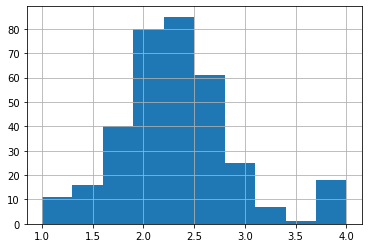

In [65]:
ist.input_score_tables['text_7_props'].embedding_cos_sim.hist()

<AxesSubplot:>

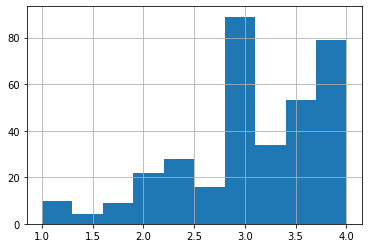

In [63]:
evalD.wordsim_df.Avg.hist()

In [25]:
new_embed_dict_master, responses_dict_master = {}, {}

# # Load all supporting files
inp = InputEmbeddings()
basis = NeighborDatasets()
evalD = EvaluationDatasets()

Input Embeddings:   0%|          | 0/7 [00:00<?, ?it/s]

OG Coverage of text_7_props: 326
Added 11 corrections to text_7_props
OG Coverage of complex: 344
Added 0 corrections to complex
OG Coverage of transe: 344
Added 0 corrections to transe
OG Coverage of abstract_first_sent: 344
Added 0 corrections to abstract_first_sent
OG Coverage of has_h: 337
Added 7 corrections to has_h
OG Coverage of has_a: 20
Added 372 corrections to has_a
OG Coverage of has_s: 234
Added 93 corrections to has_s
Embedding: text_7_props, Size: 220011, Length: 1024
Embedding: complex, Size: 241694, Length: 100
Embedding: transe, Size: 241694, Length: 100
Embedding: abstract_first_sent, Size: 241694, Length: 768
Embedding: has_h, Size: 166208, Length: 200
Embedding: has_a, Size: 28247, Length: 200
Embedding: has_s, Size: 117083, Length: 200
Fetched all input embeddings


Neighbor Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Fetched neighbour datasets: ['bert_child_par', 'bert_siblings', 'bert_all', 'probase']
Dataset: Wordsim-353
M    221
U    103
I     20
Name: category, dtype: int64
Dataset: Wordsim-353 OLD
M    280
U     44
I     25
Name: category, dtype: int64


In [26]:
inp_tsne = ReducedInputEmbeddings(inp.embed_dict_master, 100)
conc_emb_dict = inp_tsne.generate_concatenated_embedding_dict(list(set(inp.embed_dict_master.keys())))

  0%|          | 0/7 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [52]:
responses_dict, _ = ResultMetrics.compute_classification_results(
                            conc_emb_dict, evalD.old_wordsim_df, get_output_values=False, old_accuracy=None)
responses_dict

{'covered_pairs': 349,
 'accuracy': 44.69914040114613,
 'classification_report': {'I': {'precision': 0.8888888888888888,
   'recall': 0.32,
   'f1-score': 0.47058823529411764,
   'support': 25},
  'M': {'precision': 0.8320610687022901,
   'recall': 0.3892857142857143,
   'f1-score': 0.5304136253041363,
   'support': 280},
  'U': {'precision': 0.18660287081339713,
   'recall': 0.8863636363636364,
   'f1-score': 0.30830039525691694,
   'support': 44},
  'accuracy': 0.4469914040114613,
  'macro avg': {'precision': 0.6358509428015253,
   'recall': 0.531883116883117,
   'f1-score': 0.436434085285057,
   'support': 349},
  'weighted avg': {'precision': 0.7547560108156244,
   'recall': 0.4469914040114613,
   'f1-score': 0.49812532481035937,
   'support': 349}},
 'conf_matrix': array([[  8,  17,   0],
        [  1, 109, 170],
        [  0,   5,  39]]),
 'KT': 0.4188226957013864,
 'SR': 0.5855565621170609,
 'RMSE': 0.8370554555481824,
 'increase_acc': None}

In [53]:
responses_dict, _ = ResultMetrics.compute_classification_results(
                            conc_emb_dict, evalD.wordsim_df, get_output_values=False, old_accuracy=None)
responses_dict

{'covered_pairs': 344,
 'accuracy': 55.81395348837209,
 'classification_report': {'I': {'precision': 1.0,
   'recall': 0.45,
   'f1-score': 0.6206896551724138,
   'support': 20},
  'M': {'precision': 0.7777777777777778,
   'recall': 0.4434389140271493,
   'f1-score': 0.5648414985590777,
   'support': 221},
  'U': {'precision': 0.40669856459330145,
   'recall': 0.8252427184466019,
   'f1-score': 0.5448717948717948,
   'support': 103},
  'accuracy': 0.5581395348837209,
  'macro avg': {'precision': 0.7281587807903597,
   'recall': 0.5728938774912504,
   'f1-score': 0.5768009828677622,
   'support': 344},
  'weighted avg': {'precision': 0.6795896541918574,
   'recall': 0.5581395348837209,
   'f1-score': 0.5621091835953469,
   'support': 344}},
 'conf_matrix': array([[  9,  10,   1],
        [  0,  98, 123],
        [  0,  18,  85]]),
 'KT': 0.42603956544144383,
 'SR': 0.5644769083815114,
 'RMSE': 0.6932338182205002,
 'increase_acc': None}

In [73]:
ist = InputScoreTables(inp.embed_dict_master, [])
_,res_df = ResultMetrics.compute_classification_n_regression_stats(ist, 'wsim_quantiles', standard_labels=False)
res_df.to_csv('../data/retrofitting/wordsim_quantile_analysis.'+ Utils.today_date +'.csv', index=False)

Fetching new wordsim score tables and eval file
Returning averaged scores from 9 algorithms - {'text_7_props', 'topSim', 'has_s', 'has_h', 'abstract_first_sent', 'classSim', 'complex', 'transe', 'JC'}
At most 83 rows in each quartile


IndexError: list index out of range

In [65]:
ist.input_score_tables.keys()

dict_keys(['classSim', 'JC', 'topSim', 'text_7_props', 'complex', 'transe', 'abstract_first_sent', 'has_h', 'has_a', 'has_s', 'average'])

In [40]:
ist = InputScoreTables(inp.embed_dict_master, [])
_,res_df = ResultMetrics.compute_classification_n_regression_stats(ist, 'wsim_orig', standard_labels=True)
res_df.to_csv('../data/retrofitting/wordsim_all_algo_scores.'+ Utils.today_date +'.csv', index=False)

Fetching new wordsim score tables and eval file
Returning averaged scores from 9 algorithms - {'text_7_props', 'topSim', 'has_s', 'has_h', 'abstract_first_sent', 'classSim', 'complex', 'transe', 'JC'}


In [45]:
res_df[res_df.abstract_first_sent >= 3.9]

,Word 1,Word 2,ID,H_Sim,H_Dim,F_Sim,F_Dim,N_Sim,N_Dim,D_Sim,...,abstract_first_sent,abstract_first_sent_cat,has_h,has_h_cat,has_a,has_a_cat,has_s,has_s_cat,average,average_cat
72,cup,article,61,4,NaN,4,NaN,4,NaN,4,...,3.958764,U,2.872906,M,4.0,U,4.000000,U,3.482037,M
103,dollar,loss,92,3,D,3,D,4,NaN,4,...,3.999627,U,2.698693,M,4.0,U,4.000000,U,3.256196,M
104,dollar,profit,93,3,D,3,U,3,D,4,...,3.932936,U,2.713157,M,4.0,U,3.864850,U,3.175763,M
135,game,series,126,3,H,3,H,3,H,4,...,3.944594,U,3.050802,M,4.0,U,4.000000,U,3.153498,M
140,glass,magician,131,4,NaN,4,NaN,4,NaN,4,...,3.988100,U,3.684964,U,4.0,U,3.368972,M,3.457468,M
162,lad,wizard,157,4,NaN,4,NaN,4,NaN,4,...,3.958942,U,3.162558,M,4.0,U,3.647433,U,3.481917,M
169,line,insurance,164,4,NaN,3,I,4,NaN,4,...,3.990768,U,3.564862,U,4.0,U,4.000000,U,3.405219,M
175,lover,quarrel,170,3,D,3,U,4,NaN,3,...,3.956682,U,4.000000,U,4.0,U,4.000000,U,3.336049,M
187,ministry,culture,185,4,NaN,3,D,4,NaN,4,...,3.923127,U,2.928390,M,4.0,U,3.639812,U,3.331104,M
216,noon,string,214,4,NaN,4,NaN,4,NaN,4,...,3.965832,U,3.191536,M,4.0,U,4.000000,U,3.321735,M


In [ ]:
ist = InputScoreTables(inp.embed_dict_master, set(['has_a']), False)
_,res_df = ResultMetrics.compute_classification_n_regression_stats(ist, 'wsim_old', standard_labels=True)
res_df.to_csv('../data/retrofitting/wordsim_all_algo_scores.wsim_old.'+ Utils.today_date +'.csv', index=False)

In [28]:
%%time
start_master_time = time()


# Wordsim executions
# new_embed_dict_master['wordsim'], responses_dict_master['wordsim'] = RetrofittingProcedures.execute_all_unsupervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, basis.neighbors_dict_master, 
#                                                                             evalD.wordsim_df, "wordsim_ind")

# # ist = InputScoreTables(inp.embed_dict_master)
# # _ = ResultMetrics.compute_classification_n_regression_stats(ist, 'wsim')

# # ist = InputScoreTables(inp.embed_dict_master, False)
# # _ = ResultMetrics.compute_classification_n_regression_stats(ist, 'wsim_old')

# print("Analysed wordsim_ind")

# SVMProcedures.execute_all_supervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, 
#                                             new_embed_dict_master['wordsim'], 
#                                             evalD.wordsim_df, "SVC_Wordsim",
#                                             comb_mode = False, SVC_or_SVR = 'SVC')
# print("Analysed SVC_Wordsim")

SVMProcedures.execute_all_supervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, 
                                            new_embed_dict_master['wordsim'], 
                                            evalD.wordsim_df, "SVR_Wordsim",
                                            comb_mode = False, SVC_or_SVR = 'SVR')
print("Analysed SVR_Wordsim")

# RetrofittingProcedures.save_all_embeddings(new_embed_dict_master['wordsim'])

# SVMProcedures.execute_all_supervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, 
#                                             new_embed_dict_master['wordsim'], 
#                                             evalD.wordsim_df, "SVR_Wordsim",
#                                             comb_mode = True, SVC_or_SVR = 'SVR')
# print("Analysed SVR_Wordsim combinatrics")

# new_embed_dict_master, responses_dict_master = {}, {}

                                                                                                                               
                                                                                                                               
                                                                                                                               
# # Wiki CS executions
# new_embed_dict_master['wiki_cs'], responses_dict_master['wiki_cs'] = RetrofittingProcedures.execute_all_unsupervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, basis.neighbors_dict_master, 
#                                                           evalD.wiki_cs_df, "wiki_cs_ind")
# print("Analysed wiki_cs_ind")

# SVMProcedures.execute_all_supervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master,
#                                             new_embed_dict_master['wiki_cs'],
#                                             evalD.wordsim_df, "SVC_Wiki_CS",
#                                             comb_mode = False, SVC_or_SVR = 'SVC')
# print("Analysed SVC_Wiki_CS")

                                                                                                                               
                                                                                                                               
                                                                                                                               
# # Conceptnet executions
# new_embed_dict_master['conceptnet'], responses_dict_master['conceptnet'] = RetrofittingProcedures.execute_all_unsupervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master, basis.neighbors_dict_master, 
#                                                           evalD.concept_net_df, "concept_net_ind")
# print("Analysed concept_net_ind")

# SVMProcedures.execute_all_supervised_scenarios(inp.emb_list, basis.basis_list, inp.embed_dict_master,
#                                             new_embed_dict_master['conceptnet'],
#                                             evalD.wordsim_df, "SVC_Conceptnet",
#                                             comb_mode = False, SVC_or_SVR = 'SVC')
# print("Analysed SVC_Conceptnet")

# print(f"Time taken for end-to-end execution: {time() - start_master_time}s")

  0%|          | 0/84 [00:00<?, ?it/s]

Analysed SVR_Wordsim
CPU times: user 22.1 s, sys: 401 ms, total: 22.5 s
Wall time: 41.9 s


# Evaluation Datasets

In [ ]:
bioDF = pd.read_csv('../data/pedersen2007measures_table1.csv')

In [ ]:
bioDF.head()

In [ ]:
bioDFNodesSet = set(bioDF.Term1_kg_id.to_list() + bioDF.Term2_kg_id.to_list())

In [ ]:
P279childParNodesSet = set(p279WordSimSeededDF_wabs_text.node1.to_list() + p279WordSimSeededDF_wabs_text.node2.to_list())
P279siblingsNodesSet = set(p279Seeded_SiblingsDF3_wabs_text.node1.to_list() + p279Seeded_SiblingsDF3_wabs_text.node2.to_list())

In [ ]:
sum(bioDF.Term1_kg_id.apply(lambda p: p in P279childParNodesSet or p in P279siblingsNodesSet)), \
sum(bioDF.Term2_kg_id.apply(lambda p: p in P279childParNodesSet or p in P279siblingsNodesSet))

In [ ]:
probaseNodesSet = set(probDF_Qnodes_DF_WQnodes1_subset.node1.to_list() + probDF_Qnodes_DF_WQnodes1_subset.node2.to_list())

sum(bioDF.Term1_kg_id.apply(lambda p: p in probaseNodesSet)), \
sum(bioDF.Term2_kg_id.apply(lambda p: p in probaseNodesSet))